# AML Assignment 4
## (Charles) Adam Finch -- finchca

## Question 1: Bagging and Boosting

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder


import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

### Write a function to implement AdaBoost:

In [2]:
# I added one other input to the function (max tree depth) to help with my experimentation:
def AdaBoost(X_train, y_train, X_test, y_test, T, tree_depth):

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    n = X_train.shape[0] # Number of features (training)
    n_test = X_test.shape[0] # Number of features (test)
    weights = np.ones(n) / n # 1. Initialize a vector of n uniform weights w1, all with weight 1/n to start.
    
    train_preds = np.zeros((T, n))
    test_preds = np.zeros((T, n_test))
    train_errors = np.zeros(T)
    test_errors = np.zeros(T)
    betas = np.zeros((T,1))
    
    
    for t in range(T): # 2. for t = 1 ... T
        model = DecisionTreeClassifier(max_depth = tree_depth) # 3. Train model ht on X, y with instance weights wt
        model.fit(X_train, y_train, sample_weight = weights)
        ht_train = model.predict(X_train)
        ht_test = model.predict(X_test)
         
        et_train = np.sum(weights * (y_train != ht_train)) # 4. Compute the weighted training error of ht
        et_test = np.sum(y_test != ht_test) / n_test # test error
        
        beta = 0.5 * np.log((1 - et_train) / et_train) # 5. Choose Bt = 1/2ln[(1-et) / et]
        
        weights *= np.exp(-1.0 * beta * y_train * ht_train) # 6. Update all instance weights
        
        weights /= np.sum(weights) # 7. Normalize wt+1 to be a distribution
        
        # Store training errors and predictions for each runthrough 
        train_errors[t] = et_train
        test_errors[t] = et_test
        train_preds[t,:] = ht_train
        test_preds[t,:] = ht_test
        betas[t] = beta
        
        # 8. End For
    
    h_final_train = np.sign(np.sum(np.multiply(train_preds, betas), axis=0)) # 9. Return the hypothesis
    h_final_test = np.sign(np.sum(np.multiply(test_preds, betas), axis = 0))
    
    return h_final_train, h_final_test, train_errors, test_errors

### Write a function to implement Bagging:

In [3]:
# I added one other input to the function (max tree depth) to help with my experimentation:
def Bagging(X_train, y_train, X_test, y_test, T, tree_depth):

    n = X_train.shape[0] # Number of features (training)
    n_test = X_test.shape[0] # Number of features (test)
    
    train_preds = np.zeros((T, n))
    test_preds = np.zeros((T, n_test))
    train_errors = np.zeros(T)
    test_errors = np.zeros(T)
    
    for t in range(T):
        # Randomly choose a sample the same size as training (with replacement)
        chosen_idxs = np.random.choice(n, n, replace=True) 
        X_bag = X_train.iloc[chosen_idxs]
        y_bag = y_train[chosen_idxs]
        
        #Fit sampled data on a base classifier
        model = DecisionTreeClassifier(max_depth = tree_depth)
        model.fit(X_bag, y_bag) 
        
        y_hat_train = model.predict(X_train)
        y_hat_test = model.predict(X_test)
        
        #Training and Test Errors:
        et_train = np.sum(y_hat_train != y_train)
        et_test = np.sum(y_hat_test != y_test)
        
        train_errors[t] = et_train
        test_errors[t] = et_test
        train_preds[t,:] = y_hat_train
        test_preds[t,:] = y_hat_test
    
    #Final prediction based on majority voting among all rounds
    final_train_preds = np.sign(np.sum(train_preds, axis=0))
    final_test_preds = np.sign(np.sum(test_preds, axis = 0))

    return final_train_preds, final_test_preds, train_errors, test_errors

Now that I have written my functions, I want to load in one of the datasets to see how well it performs. I can also compare my algorithms against sklearn's AdaBoost and Bagging functions to ensure that I implemented them correctly. 

I'll start with the "letter" dataset:

In [4]:
#Load in the "letter" dataset
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
letter_recognition = fetch_ucirepo(id=59) 
  
# data (as pandas dataframes) 
X_letter = letter_recognition.data.features 
y_letter = letter_recognition.data.targets 


In [5]:
# Filter out all letters except for C and G:

mask = (y_letter['lettr']=='C') | (y_letter['lettr'] == 'G')
X_letter = X_letter[mask]
y_letter = y_letter[mask]

print(X_letter.shape)
print(y_letter.shape)

(1509, 16)
(1509, 1)


In [6]:
# Assignment says to use 500 training and 1009 test examples:

X_train_letter, X_test_letter, y_train_letter, y_test_letter = train_test_split(
    X_letter, y_letter, test_size=1009, train_size=500, random_state=42, stratify = y_letter)

print(X_train_letter.shape)
print(X_test_letter.shape)

print(y_train_letter)

(500, 16)
(1009, 16)
      lettr
16067     G
1876      C
13182     G
8853      C
9062      G
...     ...
18797     C
10973     C
14535     C
10216     C
8326      C

[500 rows x 1 columns]


AdaBoost and Bagging functions rely on the y label encoded as either -1 or 1 in order for the calculations to work. I'll accomplish this using label encoder and some manipulation:

In [7]:
# Use label encoder to encode y:

label_encoder = LabelEncoder()

# Fit and transform the labels
y_train_letter = label_encoder.fit_transform(y_train_letter['lettr'])
y_test_letter = label_encoder.fit_transform(y_test_letter['lettr'])

# G will be coded as 1, and C will be coded as -1
y_train_letter = 2 * y_train_letter - 1
y_test_letter = 2 * y_test_letter - 1

print(y_train_letter)

[ 1 -1  1 -1  1 -1 -1  1  1 -1 -1  1 -1 -1 -1 -1 -1  1 -1  1  1  1  1 -1
 -1 -1 -1 -1 -1  1 -1  1  1 -1  1  1 -1 -1 -1  1  1 -1  1 -1  1 -1 -1  1
 -1  1  1  1  1 -1 -1 -1  1 -1 -1 -1  1  1  1 -1 -1  1  1  1 -1 -1  1  1
  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1  1 -1 -1 -1  1  1 -1  1 -1 -1 -1  1
 -1 -1 -1  1 -1 -1  1  1 -1 -1 -1  1  1  1  1  1  1  1  1 -1  1 -1  1 -1
  1 -1 -1  1 -1  1  1 -1 -1 -1  1  1  1  1 -1  1 -1 -1  1  1  1  1 -1  1
  1  1  1  1 -1 -1 -1  1  1  1  1 -1  1  1 -1  1  1 -1 -1 -1  1  1  1 -1
  1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1 -1  1 -1 -1  1
 -1  1  1 -1 -1  1  1 -1 -1 -1  1 -1 -1  1  1 -1  1 -1  1  1  1  1  1  1
  1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1  1 -1 -1 -1
 -1 -1  1  1  1  1  1  1 -1 -1 -1  1  1  1  1 -1 -1 -1  1 -1 -1  1  1 -1
 -1 -1 -1  1  1 -1 -1 -1 -1  1 -1  1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1  1
  1  1 -1  1  1 -1  1 -1 -1 -1  1  1 -1 -1  1  1 -1  1 -1  1  1  1  1  1
  1 -1 -1  1  1  1  1  1  1 -1  1 -1  1 -1  1 -1  1

Now the letter dataset is in the proper format for me to test out my functions! First I'll test AdaBoost:

In [8]:
# Test AdaBoost function
T = 15  # Number of boosting rounds
max_depth = 1 # Depth of decision trees

h_final_train, h_final_test, train_errors, test_errors = AdaBoost(X_train_letter, y_train_letter,
                                                                  X_test_letter, y_test_letter, T,
                                                                  max_depth)

overall_train_error = np.sum(h_final_train != y_train_letter) / X_train_letter.shape[0]
overall_test_error = np.sum(h_final_test != y_test_letter) / X_test_letter.shape[0]
    
print(f"AdaBoost Training Error: {np.round(overall_train_error, 3)}")
print(f"AdaBoost Testing Error: {np.round(overall_test_error, 3)}")
    
overall_train_acc = accuracy_score(y_train_letter, h_final_train)
overall_test_acc = accuracy_score(y_test_letter, h_final_test)
    
print(f"\nAdaBoost Training Accuracy: {np.round(overall_train_acc, 3)}")
print(f"AdaBoost Testing Accuracy: {np.round(overall_test_acc, 3)}")

AdaBoost Training Error: 0.064
AdaBoost Testing Error: 0.094

AdaBoost Training Accuracy: 0.936
AdaBoost Testing Accuracy: 0.906


In order to make sure I implemented my function correctly, I want to use sklearn's AdaBoost as a benchmark:

In [9]:
from sklearn.ensemble import AdaBoostClassifier

skl_adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                  n_estimators=15, algorithm = 'SAMME')
skl_adaboost.fit(X_train_letter, y_train_letter)

skl_train_preds = skl_adaboost.predict(X_train_letter)
skl_test_preds = skl_adaboost.predict(X_test_letter)

skl_train_accuracy = accuracy_score(y_train_letter, skl_train_preds)
skl_test_accuracy = accuracy_score(y_test_letter, skl_test_preds)

# Print or compare the accuracies
print(f"Scikit-learn AdaBoost Training Accuracy: {np.round(skl_train_accuracy, 3)}")
print(f"Scikit-learn AdaBoost Testing Accuracy: {np.round(skl_test_accuracy, 3)}")

Scikit-learn AdaBoost Training Accuracy: 0.936
Scikit-learn AdaBoost Testing Accuracy: 0.906


My function achieved very similar results, giving me confidence that it is implemented correctly. Next I want to test out the bagging function:

In [10]:
# Test Bagging function
T = 15  # Number of bagging samples
max_depth = 1 # Depth of decision trees

final_train_preds, final_test_preds, train_errors, test_errors = Bagging(X_train_letter, y_train_letter,
                                                                         X_test_letter, y_test_letter, T,
                                                                         max_depth)

overall_train_error = np.sum(final_train_preds != y_train_letter) / X_train_letter.shape[0]
overall_test_error = np.sum(final_test_preds != y_test_letter) / X_test_letter.shape[0]
    
print(f"Bagging Training Error: {np.round(overall_train_error, 3)}")
print(f"Bagging Testing Error: {np.round(overall_test_error, 3)}")
    
overall_train_acc = accuracy_score(y_train_letter, final_train_preds)
overall_test_acc = accuracy_score(y_test_letter, final_test_preds)
    
print(f"\nBagging Training Accuracy: {np.round(overall_train_acc, 3)}")
print(f"Bagging Testing Accuracy: {np.round(overall_test_acc, 3)}")

Bagging Training Error: 0.198
Bagging Testing Error: 0.228

Bagging Training Accuracy: 0.802
Bagging Testing Accuracy: 0.772


In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

base_classifier = DecisionTreeClassifier(max_depth=1)
skl_bagging = BaggingClassifier(base_classifier, n_estimators=15)
skl_bagging.fit(X_train_letter, y_train_letter)

skl_train_preds = skl_bagging.predict(X_train_letter)
skl_test_preds = skl_bagging.predict(X_test_letter)

overall_train_acc = accuracy_score(y_train_letter, skl_train_preds)
overall_test_acc = accuracy_score(y_test_letter, skl_test_preds)

print(f"Sklearn Bagging Training Accuracy: {np.round(overall_train_acc, 3)}")
print(f"Sklearn Bagging Testing Accuracy: {np.round(overall_test_acc, 3)}")

Sklearn Bagging Training Accuracy: 0.802
Sklearn Bagging Testing Accuracy: 0.772


Once again, my function performed very similarly to sklearn's. This gives me confidence that both my AdaBoost and Bagging functions have been implemented correctly. 

Now I need to load in the other two datasets and start running experiments to compare the two algorithms.

Next up is the "credit" dataset:

In [12]:
#Load in the "credit" dataset:

# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
X_credit = statlog_german_credit_data.data.features 
y_credit = statlog_german_credit_data.data.targets 

print(X_credit.shape)
print(y_credit.shape)

(1000, 20)
(1000, 1)


In [13]:
#For this dataset, there are a lot of categorical vars, which won't work with the DecisionTree base model.
#I convert the whole dataset to numeric types through one hot encoding:

cat_vars = []

for column in X_credit:
    if X_credit[column].dtype == 'object':
        cat_vars.append(column)

print(cat_vars)

['Attribute1', 'Attribute3', 'Attribute4', 'Attribute6', 'Attribute7', 'Attribute9', 'Attribute10', 'Attribute12', 'Attribute14', 'Attribute15', 'Attribute17', 'Attribute19', 'Attribute20']


In [14]:
encoder = OneHotEncoder(drop='first', sparse=False)
X_credit_encoded = pd.DataFrame(encoder.fit_transform(X_credit[cat_vars]))

# Drop the original categorical columns from X_credit
X_credit = X_credit.drop(columns=cat_vars)

# Concatenate the one-hot encoded columns to X_credit
X_credit = pd.concat([X_credit, X_credit_encoded], axis=1)


In [15]:
X_credit.columns = X_credit.columns.astype(str)

print(X_credit)

     Attribute2  Attribute5  Attribute8  Attribute11  Attribute13  \
0             6        1169           4            4           67   
1            48        5951           2            2           22   
2            12        2096           2            3           49   
3            42        7882           2            4           45   
4            24        4870           3            4           53   
..          ...         ...         ...          ...          ...   
995          12        1736           3            4           31   
996          30        3857           4            4           40   
997          12         804           4            4           38   
998          45        1845           4            4           23   
999          45        4576           3            4           27   

     Attribute16  Attribute18    0    1    2  ...   31   32   33   34   35  \
0              2            1  0.0  0.0  0.0  ...  0.0  0.0  1.0  1.0  0.0   
1              

In [16]:
# Assignment says to use 400 training and  600 test examples:

X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(
    X_credit, y_credit, test_size=600, train_size=400, random_state=42, stratify = y_credit)

print(X_train_credit.shape)
print(X_test_credit.shape)

print(y_train_credit)

(400, 48)
(600, 48)
     class
384      1
811      1
758      1
213      2
76       2
..     ...
218      1
251      1
994      1
298      1
918      2

[400 rows x 1 columns]


Right now, good credit is coded as 1 and bad credit is coded as 2. For my functions to work properly, I want to keep good credit coded as 1, but change bad credit so that it is coded as -1.

In [17]:
y_train_credit['class'] = y_train_credit['class'].replace(2,-1)
y_test_credit['class'] = y_test_credit['class'].replace(2,-1)

y_train_credit = y_train_credit['class'].ravel()
y_test_credit = y_test_credit['class'].ravel()

print(y_train_credit)


[ 1  1  1 -1 -1  1  1 -1  1 -1  1  1 -1  1 -1  1 -1  1  1  1  1  1 -1 -1
  1  1  1 -1  1 -1  1  1  1  1  1  1  1 -1 -1 -1  1  1  1  1  1 -1 -1 -1
  1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1 -1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1
 -1 -1  1 -1  1  1 -1  1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1  1  1  1  1 -1 -1 -1  1  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1 -1 -1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1
 -1  1  1  1 -1  1  1 -1 -1 -1  1  1  1 -1  1  1  1  1  1  1 -1  1  1  1
  1 -1 -1  1  1  1  1 -1  1  1 -1  1 -1  1  1  1  1  1 -1 -1  1  1  1  1
  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1  1 -1  1  1  1  1 -1  1  1  1 -1
 -1 -1 -1  1  1  1  1  1 -1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1 -1
  1  1  1 -1  1  1  1  1 -1  1  1  1 -1  1  1 -1  1  1  1  1 -1  1  1  1
 -1  1  1  1  1  1 -1 -1  1 -1  1  1 -1  1 -1 -1 -1  1  1  1 -1 -1 -1 -1
  1  1  1  1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1

Now I have good training and test sets for the credit dataset to use during my experimentation. 

Finally, I need to load in the "spam" dataset:

In [18]:
# fetch dataset 
spambase = fetch_ucirepo(id=94) 
  
# data (as pandas dataframes) 
X_spam = spambase.data.features 
y_spam = spambase.data.targets 

print(X_spam.shape)
print(y_spam.shape)

(4601, 57)
(4601, 1)


In [19]:
# Assignment says to use 1000 training and 3601 test examples:

X_train_spam, X_test_spam, y_train_spam, y_test_spam = train_test_split(
    X_spam, y_spam, test_size=3601, train_size=1000, random_state=42, stratify = y_spam)

print(X_train_spam.shape)
print(X_test_spam.shape)

print(y_train_spam)

(1000, 57)
(3601, 57)
      Class
3625      0
4225      0
1948      0
2181      0
4499      0
...     ...
1410      1
1427      1
3689      0
10        1
2357      0

[1000 rows x 1 columns]


Right now, spam is coded as 1 and not spam is coded as 0. I want to change not spam so it is coded as -1. 

In [20]:
y_train_spam['Class'] = y_train_spam['Class'].replace(0,-1)
y_test_spam['Class'] = y_test_spam['Class'].replace(0,-1)

y_train_spam = y_train_spam['Class'].values.ravel()
y_test_spam = y_test_spam['Class'].values.ravel()

print(y_train_spam)

[-1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1  1 -1  1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1
 -1  1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1
 -1  1  1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1  1 -1 -1 -1  1 -1
 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1  1 -1 -1 -1  1 -1 -1
  1 -1 -1 -1 -1 -1  1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1
 -1 -1 -1  1 -1 -1  1 -1 -1  1  1 -1  1 -1  1  1 -1  1 -1 -1 -1  1 -1 -1
 -1 -1  1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1  1
  1  1 -1  1  1 -1  1 -1  1 -1 -1  1 -1  1 -1 -1 -1  1 -1  1 -1 -1  1 -1
 -1 -1 -1 -1  1 -1 -1 -1  1 -1  1  1  1 -1  1  1 -1 -1  1  1  1 -1 -1 -1
 -1  1  1 -1  1  1 -1 -1 -1  1 -1 -1  1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1
  1  1  1 -1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1 -1  1 -1 -1  1  1 -1
  1 -1 -1 -1 -1  1  1  1  1  1  1  1  1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1
 -1  1  1 -1  1  1 -1  1 -1  1 -1  1  1  1  1 -1 -1

Now that my datasets are all loaded in successfully, it's time to run some experiments.

### Experimentation:

The goal of my experimentation is to figure out which algorithm is most effective when, and why. 

For my experiment, I am going to create a function that will go through a dataset and iteratively call the AdaBoost and Bagging algorithms implemented above for several different tree depths, and several different rounds T. This will help me to gain an understanding as to which algorithm might fare better for different situations. 

In [67]:
def plot_test_errors(algorithm, X_train, y_train, X_test, y_test, depths, rounds, dataset):
    errors = []

    for depth in depths:
        error_depth = []
        for round_num in rounds:
            # Train the model
            if algorithm == "AdaBoost":
                final_train_preds, final_test_preds, train_errors, test_errors = AdaBoost(
                    X_train, y_train, X_test, y_test, T=round_num, tree_depth=depth)
                
            elif algorithm == "Bagging":
                final_train_preds, final_test_preds, train_errors, test_errors = Bagging(
                    X_train, y_train, X_test, y_test, T=round_num, tree_depth=depth)
            
            
            # Evaluate on the test set
            test_error = np.sum(final_test_preds != y_test) / X_test.shape[0]
            error_depth.append(test_error)

        errors.append(error_depth)

    # Plotting
    for i, depth in enumerate(depths):
        plt.plot(rounds, errors[i], label=f"Depth {depth}")

    plt.xlabel("Number of Rounds")
    plt.ylabel("Test Error")
    plt.title(f"{dataset}: Test Error vs. Number of Rounds for {algorithm}")
    plt.legend()
    plt.show()

### Plots of the test error for the various algorithms and datasets as a function of the number of rounds

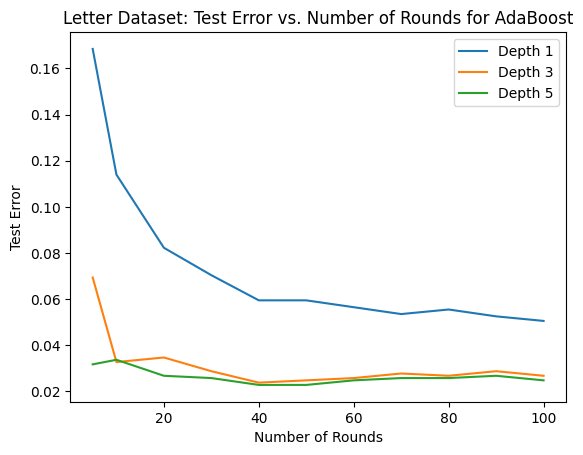

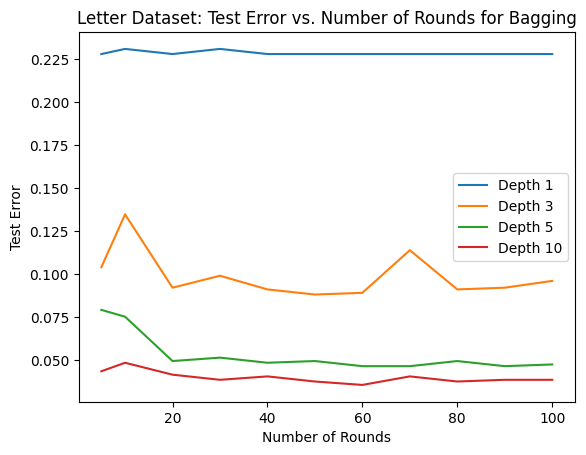

In [85]:
depths_to_try = [1, 3, 5, 10]
rounds_to_try = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

plot_test_errors("AdaBoost", X_train_letter, y_train_letter, 
                 X_test_letter, y_test_letter, [1,3,5], rounds_to_try,
                "Letter Dataset")

plot_test_errors("Bagging", X_train_letter, y_train_letter, 
                 X_test_letter, y_test_letter, depths_to_try, rounds_to_try,
                "Letter Dataset")

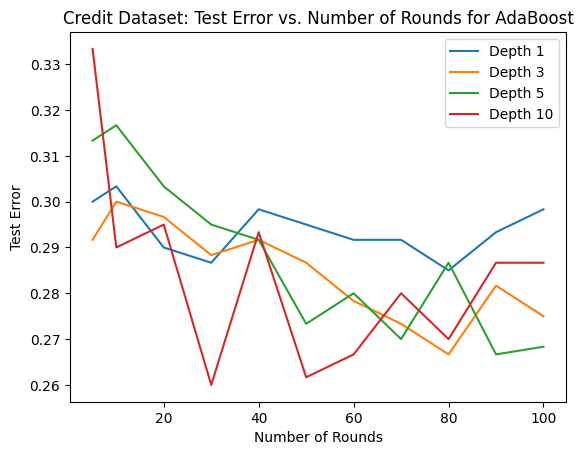

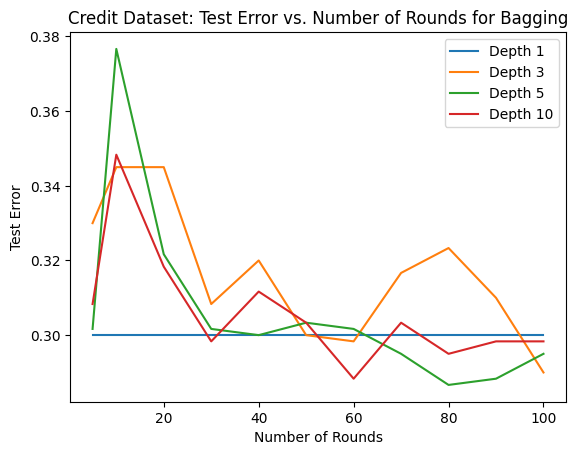

In [86]:
plot_test_errors("AdaBoost", X_train_credit, y_train_credit, X_test_credit, 
                 y_test_credit, depths_to_try, rounds_to_try, "Credit Dataset")

plot_test_errors("Bagging", X_train_credit, y_train_credit, X_test_credit, 
                 y_test_credit, depths_to_try, rounds_to_try, "Credit Dataset")

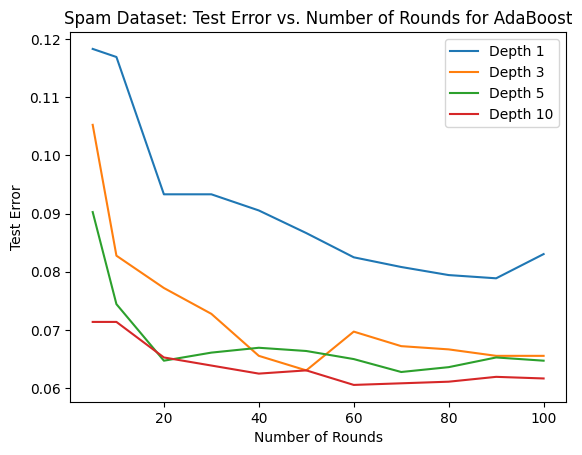

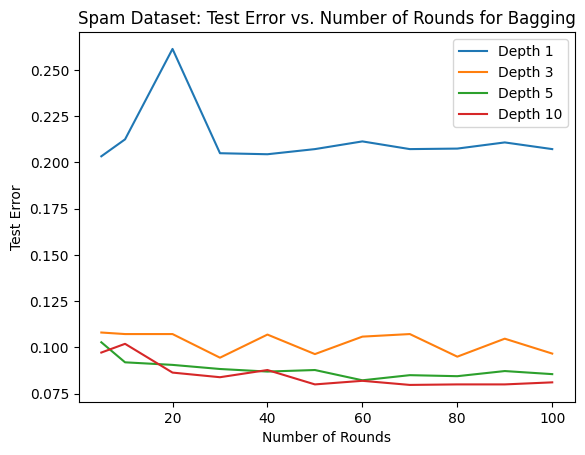

In [88]:
plot_test_errors("AdaBoost", X_train_spam, y_train_spam, X_test_spam, 
                 y_test_spam, depths_to_try, rounds_to_try, "Spam Dataset")

plot_test_errors("Bagging", X_train_spam, y_train_spam, X_test_spam, 
                 y_test_spam, depths_to_try, rounds_to_try, "Spam Dataset")

### A discussion of how the algorithms compare in performance and behavior / other observations, experiments, plots, etc. that are the result of further exploration.

AdaBoost performed quite well on these three datasets. In general, it performance increased as the number of rounds increased. However, increasing the number of rounds had the characteristic of diminishing marginal returns. For example -- performance improved significantly by increasing from 10 to 20 rounds of AdaBoost, whereas increasing from 90 to 100 rounds yielded comparatively less improvement. 

Bagging also yielded postiive results, although in general the test error rates for Bagging were higher than the test error rates for AdaBoost. Bagging showed less sensitivity to the number of rounds, which makes sense given that it is consistently resampling from the same training dataset rather than changing the weights. Bagging also exhibits slightly different behavior each time it is run (unless you standardize the random_state that you are using). This explains why there are some unexpected jumps in test error, especially with shallow trees and a low number of rounds. 

For two of the datasets (spam and letter) deeper trees performed better than a shallower tree stump with depth equal to 1 on both AdaBoost and Bagging algorithms. However, the increase in performance for AdaBoost when switching to a deeper tree was far less than the gap in performance for bagging. This suggests that bagging is more reliant on deeper trees, and AdaBoost can perform well even when using a bunch of weak learners like decision tree stumps. 

The credit dataset was a bit of an anomoly when assessing performance on these two algorithms. This is likely due to the large amount of noise present in this dataset. After one hot encoding the categorical variables, there were a lot of features for the Decision Trees to parse through. As such, the testing errors were higher for this dataset compared to the other two. This dataset was less effected by depth of the decision trees, but increasing the number of rounds seemed to help improve performance for both AdaBoost and Bagging. I suspect that more in depth preprocessing (potentially using an ordinal encoder rather than one hot encoding categorical variables) could help to improve performance for the credit dataset. 

In addition to the performance characteristics, I also experimented on the time complexity of the AdaBoost and Bagging algorithms. I discovered that AdaBoost is generally more time-consuming than Bagging. This result makes sense given the sequential nature of AdaBoost, where each weak learner is trained based on the mistakes of its predecessor. This predictably resulted in longer training times, especially as the number of rounds increases.

Interpretability of the models produced by these algorithms is another important factor to take into account. AdaBoost prioritizes misclassified occurrences more often, giving them greater weights in ensuing rounds. Because it could give priority to intricate areas of the feature space where misclassifications happen, this emphasis on errors could make the final ensemble model more difficult to understand. When utilizing simpler base learners, bagging—which involves averaging predictions from numerous models—tends to be more resilient to noise and outliers, which could lead to a more interpretable model. This is particularly clear in datasets with a lot of noise, as the "credit" dataset displayed above. 

In conclusion, the choice between AdaBoost and Bagging depends on the specific characteristics of the dataset and the goals of the modeling task. AdaBoost may be preferred when the emphasis is on accuracy and the dataset is not too large. On the other hand, Bagging could be a better choice for larger datasets, as it tends to be more computationally efficient, and when interpretability and resistance to overfitting are crucial considerations. The nuances in their behavior across different datasets highlight the importance of understanding the underlying data characteristics when selecting an ensemble learning approach.